Imports

In [1]:
import eng_to_ipa as ipa
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.models import  Sequential, Model
from tensorflow.keras.layers import Layer, Concatenate, Input, Masking, LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from nltk.translate.bleu_score import sentence_bleu

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


Num GPUs: 1


Load Data (data file already created in data_import.py)

In [2]:
'''
file = open('words.txt','r')
lines = file.readlines()
file.close()

file = open('data.csv','w')

file.write('word,pronunciation\n')
for word in lines:
    if ipa.isin_cmu(word):
        line = word.strip('\n') + ',' + ipa.convert(word) + '\n'
        file.write(line)

file.close()
'''

"\nfile = open('words.txt','r')\nlines = file.readlines()\nfile.close()\n\nfile = open('data.csv','w')\n\nfile.write('word,pronunciation\n')\nfor word in lines:\n    if ipa.isin_cmu(word):\n        line = word.strip('\n') + ',' + ipa.convert(word) + '\n'\n        file.write(line)\n\nfile.close()\n"

Data Processing

In [3]:
df = pd.read_csv ('data.csv',delimiter=',')

df.word = df.word.astype(str) 
df.pronunciation = df.pronunciation.astype(str) 

#df.applymap(lambda s: s.replace(s,' '.join(str(s))))
df['word'] = df['word'].str.replace('',' ')
df['pronunciation'] = df['pronunciation'].str.replace('',' ')

MAX_NUM_WORDS = 40000

# 10% for val, 10% for test, 70% for train
val_size = int(df.shape[0] * 0.1)
test_size = int(df.shape[0] * 0.1)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_words, train_pronounciations = list(train_df.word), list(train_df.pronunciation)
val_words, val_pronounciations     = list(val_df.word), list(val_df.pronunciation)
test_words, test_pronounciations   = list(test_df.word), list(test_df.pronunciation)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_pronounciations) + len(val_pronounciations) + len(test_pronounciations)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_pronounciations)}\n"
    f"Val size: {len(val_pronounciations)}\n"
    f"Test size: {len(test_pronounciations)}\n"
)

for i in range(len(train_pronounciations)):
    train_pronounciations[i] = "@" + train_pronounciations[i] + "#"

for i in range(len(val_pronounciations)):
    val_pronounciations[i] = "@" + val_pronounciations[i] + "#"

for i in range(len(test_pronounciations)):
    test_pronounciations[i] = "@" + test_pronounciations[i] + "#"

ipa_tokenizer = Tokenizer(num_words = MAX_NUM_WORDS, filters = '')
ipa_tokenizer.fit_on_texts(train_pronounciations)
ipa_int_seq = ipa_tokenizer.texts_to_sequences(train_pronounciations)

ipa_word_to_indx = ipa_tokenizer.word_index

max_ipa_len = max(len(sen) for sen in ipa_int_seq)

padded_tokenized_ipa = tf.keras.preprocessing.sequence.pad_sequences(ipa_int_seq, maxlen = max_ipa_len, padding = 'post', value = 0)

padded_tokenized_ipa.shape

print(len(ipa_tokenizer.index_word))
print(ipa_tokenizer.word_index["@"])


val_tokenizer = Tokenizer(num_words = MAX_NUM_WORDS, filters = '')
val_tokenizer.fit_on_texts(val_pronounciations)
val_int_seq = val_tokenizer.texts_to_sequences(val_pronounciations)

val_word_to_indx = val_tokenizer.word_index

max_val_len = max(len(sen) for sen in val_int_seq)

padded_tokenized_val = tf.keras.preprocessing.sequence.pad_sequences(val_int_seq, maxlen = max_val_len, padding = 'post', value = 0)

padded_tokenized_val.shape


Size of initial data: 40315
Train size: 32253
Val size: 4031
Test size: 4031

38
1


(4031, 19)

In [4]:

train_data = tf.data.Dataset.from_tensor_slices((train_words, padded_tokenized_ipa))
valid_data = tf.data.Dataset.from_tensor_slices((val_words, padded_tokenized_val))

def str_split(e, g):
    e = tf.strings.split(e)
    return e, g
 
train_data = train_data.map(str_split)
valid_data = valid_data.map(str_split)
       
embedding_layer = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")    
    
def embed_english(x, y):
    return embedding_layer(x), y
 
train_data = train_data.map(embed_english)
valid_data = valid_data.map(embed_english)


def remove_long_sentence(e, g):
    return tf.shape(e)[0] <= 13
 
train_data = train_data.filter(remove_long_sentence)
valid_data = valid_data.filter(remove_long_sentence)


def pad_english(e, g):
    return tf.pad(e, paddings = [[13-tf.shape(e)[0],0], [0,0]], mode='CONSTANT', constant_values=0), g
 
train_data = train_data.map(pad_english)
valid_data = valid_data.map(pad_english)

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

print(train_data.element_spec)
print(valid_data.element_spec)

for e, g in train_data.take(1):
    print(e.shape)
    print(g)
 
for e, g in valid_data.take(1):
    print(e.shape)
    print(g)


(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.int32, name=None))
(16, 13, 128)
tf.Tensor(
[[ 1  5  4 33  3  5  8  3  9 13  2  0  0  0  0  0  0  0  0  0  0]
 [ 1 10  9 24  4 15  3  5 13  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 16 15 19  5 12 21  9  3 32 12  2  0  0  0  0  0  0  0  0  0]
 [ 1  6  3  5 16  8  6  5 12  3  9  2  0  0  0  0  0  0  0  0  0]
 [ 1 16 10  8  6  4  5 12  3  5 13  2  0  0  0  0  0  0  0  0  0]
 [ 1 23 26 20  6 26 20 10 21 14 12  4 22  2  0  0  0  0  0  0  0]
 [ 1 28  3 27  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 31 25  9  6  8  4 22  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 14  5 26 20  6  5 17 10  6  2  0  0  0  0  0  0  0  0  0  0]
 [ 1  4 22 10 34 30 19 18  4  6  3  5 13  2  0  0  0  0  0  0  0]
 [ 1 14 16 13  3  7  6  8  2  0  0  0  0  0  0  0  0  0  0  0  0]
 

In [5]:
class CustomLayer(Layer):
 
    def __init__(self, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.embed = tf.Variable(initial_value=tf.zeros(shape=(1,128)), trainable=True, dtype='float32')
         
    def call(self, inputs):
        x = tf.tile(self.embed, [tf.shape(inputs)[0], 1])
        x = tf.expand_dims(x, axis=1)
        return tf.concat([inputs, x], axis=1)


In [6]:
custom_layer = CustomLayer()
e, g = next(iter(train_data.take(1)))
print(e.shape)
o = custom_layer(e)
o.shape

(16, 13, 128)


TensorShape([16, 14, 128])

In [15]:
inputs = Input(batch_shape = (None, 13, 128), name='input')
x = CustomLayer(name='custom_layer')(inputs)
x = Masking(mask_value=0, name='masking_layer')(x)
x, h, c = LSTM(units=512, return_state=True, name='lstm')(x)
encoder_model = Model(inputs = inputs, outputs = [h, c], name='encoder')

encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 13, 128)]         0         
                                                                 
 custom_layer (CustomLayer)  (None, 14, 128)           128       
                                                                 
 masking_layer (Masking)     (None, 14, 128)           0         
                                                                 
 lstm (LSTM)                 [(None, 512),             1312768   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


In [8]:
#tokenizer = Tokenizer(train_words)
#pronounciation_tokenizer = Tokenizer(train_pronounciations)
#print(word_tokenizer.index_word)

In [9]:
class Decoder(Model):
     
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.embed = Embedding(input_dim=len(ipa_tokenizer.index_word)+1, output_dim=128, mask_zero=True, name='embedding_layer')
        self.lstm = LSTM(units = 512, return_state = True, return_sequences = True, name='lstm_layer')
        self.dense = Dense(len(ipa_tokenizer.index_word)+1, name='dense_layer')
         
    def call(self, inputs, hidden_state = None, cell_state = None):
        x = self.embed(inputs)
        x, hidden_state, cell_state = self.lstm(x, initial_state = [hidden_state, cell_state]) \
                                                     if hidden_state is not None and cell_state is not None else self.lstm(x)
        x = self.dense(x)
        return x, hidden_state, cell_state
 
decoder_model = Decoder(name='decoder')
e, g_in = next(iter(train_data.take(1)))
h, c = encoder_model(e)
g_out, h, c = decoder_model(g_in, h, c)
 
print(g_out.shape, h.shape, c.shape)

decoder_model.summary()

(16, 21, 39) (16, 512) (16, 512)
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  multiple                 4992      
                                                                 
 lstm_layer (LSTM)           multiple                  1312768   
                                                                 
 dense_layer (Dense)         multiple                  20007     
                                                                 
Total params: 1,337,767
Trainable params: 1,337,767
Non-trainable params: 0
_________________________________________________________________


epoch: 0, train loss: 1.1200305223464966, validation loss: 1.2953444719314575
epoch: 1, train loss: 0.61591637134552, validation loss: 1.3291772603988647
epoch: 2, train loss: 0.40657755732536316, validation loss: 1.3900686502456665
epoch: 3, train loss: 0.31587252020835876, validation loss: 1.4802213907241821
epoch: 4, train loss: 0.2671034634113312, validation loss: 1.5789763927459717
epoch: 5, train loss: 0.23648999631404877, validation loss: 1.6962484121322632


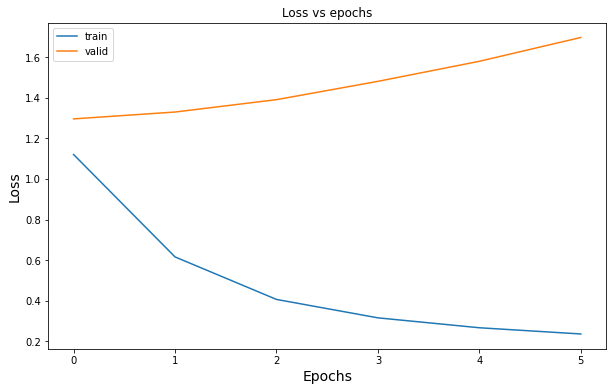

In [10]:
def get_ipa_decoder_data(g):
    
    g1 = g.numpy()
    #print(g1)
    #new_g1 =  np.delete(g1, np.where(g1 == 2), axis = 0)
    '''
    for list in g1:
        for int in range(len(list)):
            if list[int] == 2:
                np.delete(list, [int])
    '''
    
    x, y = g1.shape
    #after delete
    new_g1 = g1[g1 != 2]
    new_g1 = np.reshape(new_g1, (x, y-1))

    #print(new_g1)
    
    g2 = g.numpy()
    new_g2 =  np.delete(g2,0, axis = 1)
    new_g1 = np.pad(new_g1, ((0,0),(1,0)), 'constant')
    g_in = tf.convert_to_tensor(new_g1, dtype=tf.int32)
    
    #print(g_in)
    new_g2 = np.pad(new_g2, ((0,0),(0,1)), 'constant')
    g_out = tf.convert_to_tensor(new_g2, dtype=tf.int32)
    #print(g_out)
    
    
    
    return g_in, g_out

@tf.function
def forward_backward(encoder_model, decoder_model, e, g_in, g_out, loss):
    with tf.GradientTape() as tape:
        h, c = encoder_model(e)
        d_g_out, _, _ = decoder_model(g_in, h, c)
        cur_loss = loss(g_out, d_g_out)
        grads = tape.gradient(cur_loss, encoder_model.trainable_variables + decoder_model.trainable_variables)
    return cur_loss, grads
 
def train_encoder_decoder(encoder_model, decoder_model, num_epochs, train_data, valid_data, valid_steps, 
                          optimizer, loss, grad_fn):
    train_losses = []
    val_loasses = []
    for epoch in range(num_epochs):
        train_epoch_loss_avg = tf.keras.metrics.Mean()
        val_epoch_loss_avg = tf.keras.metrics.Mean()
        for e, g in train_data:
            g_in, g_out = get_ipa_decoder_data(g)
            #print(g_out)
            #dropout = tf.keras.layers.Dropout(rate =0.75)
            #g_out = dropout(g_out)
            train_loss, grads = grad_fn(encoder_model, decoder_model, e, g_in, g_out, loss)
            optimizer.apply_gradients(zip(grads, encoder_model.trainable_variables + decoder_model.trainable_variables))
            train_epoch_loss_avg.update_state(train_loss)    
        for e_v, g_v in valid_data.take(valid_steps):
            g_v_in, g_v_out = get_ipa_decoder_data(g_v)
            val_loss, _ = grad_fn(encoder_model, decoder_model, e_v, g_v_in, g_v_out, loss)
            val_epoch_loss_avg.update_state(val_loss)        
        print(f'epoch: {epoch}, train loss: {train_epoch_loss_avg.result()}, validation loss: {val_epoch_loss_avg.result()}')    
        train_losses.append(train_epoch_loss_avg.result())
        val_loasses.append(val_epoch_loss_avg.result())
    return train_losses, val_loasses
 
optimizer_obj = Adam(learning_rate = 1e-3)
loss_obj = SparseCategoricalCrossentropy(from_logits=True)
train_loss_results, valid_loss_results = train_encoder_decoder(encoder_model, decoder_model, 6, train_data, valid_data, 20,
                                                          optimizer_obj, loss_obj, forward_backward)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title('Loss vs epochs')
plt.plot(train_loss_results, label='train')
plt.plot(valid_loss_results, label='valid')
plt.legend()
plt.show()

In [14]:
english = test_words

indices = np.random.choice(len(english), 5)

print(indices)

test_data = tf.data.Dataset.from_tensor_slices(np.array([english[i] for i in indices]))
test_data = test_data.map(tf.strings.split)
test_data = test_data.map(embedding_layer)
test_data = test_data.filter(lambda x: tf.shape(x)[0] <= 13)
test_data = test_data.map(lambda x: tf.pad(x, paddings = [[13-tf.shape(x)[0],0], [0,0]], mode='CONSTANT', constant_values=0))
print(test_data.element_spec)
# TensorSpec(shape=(None, 128), dtype=tf.float32, name=None)

start_token = np.array(ipa_tokenizer.texts_to_sequences(['@']))
end_token = np.array(ipa_tokenizer.texts_to_sequences(['#']))
for e, i in zip(test_data.take(5), indices):

    h, c = encoder_model(tf.expand_dims(e, axis=0))
    g_t = []
    g_in = start_token
    g_out, h, c = decoder_model(g_in, h, c)
    g_t.append('')
    g_out = tf.argmax(g_out, axis=2)
    while g_out != end_token: 
        #print(g_out)
        g_out, h, c = decoder_model(g_in, h, c)
        g_out = tf.argmax(g_out, axis=2)
        g_in = g_out
        g_t.append(ipa_tokenizer.index_word.get(tf.squeeze(g_out).numpy(), 'UNK'))
    print(f'English Text: {english[i]}')
    print(f'IPA Transcription: {" ".join(g_t)}')
    print()
    

[ 332  275 2305 3624 2073]
TensorSpec(shape=(None, 128), dtype=tf.float32, name=None)
tf.Tensor([[3]], shape=(1, 1), dtype=int64)
tf.Tensor([[5]], shape=(1, 1), dtype=int64)
tf.Tensor([[36]], shape=(1, 1), dtype=int64)
tf.Tensor([[33]], shape=(1, 1), dtype=int64)
tf.Tensor([[33]], shape=(1, 1), dtype=int64)
tf.Tensor([[4]], shape=(1, 1), dtype=int64)
tf.Tensor([[18]], shape=(1, 1), dtype=int64)
tf.Tensor([[9]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[8]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[8]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[8]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[8]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[8]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[8]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1),

In [12]:
from nltk.translate.bleu_score import sentence_bleu

def bleu(model, tokenizer, sources, raw_dataset):
    actual, predicted = [], []
    for i, source in enumerate(sources):
        source = source.reshape((1, source.shape[0]))
        ipa = 


SyntaxError: invalid syntax (3819268889.py, line 7)

Model

In [ ]:
#model = Sequential()
#model.add(Embedding(len(train_words), 512, input_length=20, mask_zero=True))
#model.add(LSTM(512))
#model.add(RepeatVector(20))
#model.add(LSTM(512, return_sequences=True))
#model.add(Dense(len(train_pronounciations), activation='softmax'))
 
#rms = keras.optimizers.RMSprop(learning_rate=0.001)
#model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

#model.summary()


Performance